In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
import yfinance as yf

df = yf.Ticker("TATASTEEL.NS").history(period='5y')


In [3]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-10-23 00:00:00+05:30,123.349998,123.400002,119.699997,120.000000,30699479,0.0,0.0
2023-10-25 00:00:00+05:30,121.199997,122.800003,120.750000,121.349998,27346103,0.0,0.0
2023-10-26 00:00:00+05:30,120.849998,120.900002,118.900002,119.900002,36298907,0.0,0.0
2023-10-27 00:00:00+05:30,120.500000,121.800003,119.500000,119.900002,28424007,0.0,0.0
2023-10-30 00:00:00+05:30,121.050003,121.250000,118.949997,119.150002,18753217,0.0,0.0


In [4]:
df1 = df.reset_index()['Close']

In [5]:
df1

0        48.190277
1        47.281101
2        47.515865
3        49.005539
4        49.295788
           ...    
1231    120.000000
1232    121.349998
1233    119.900002
1234    119.900002
1235    119.150002
Name: Close, Length: 1236, dtype: float64

In [6]:
df1.shape

(1236,)

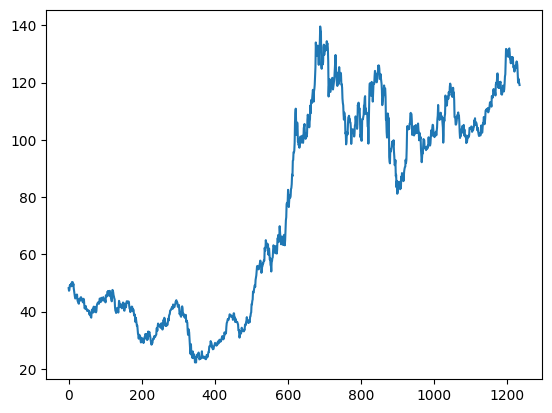

In [7]:
plt.plot(df1)

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [10]:
def create_dataset(dataset,time_step=1):
  dataX,dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)

In [11]:
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [12]:
X_train.shape

(702, 100)

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


In [14]:
X_train.shape

(702, 100, 1)

In [15]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs=100,batch_size = 64,verbose=1)

Epoch 1/100
11/11 [==============================] - 21s 738ms/step - loss: 0.0753 - val_loss: 0.0051
Epoch 2/100
11/11 [==============================] - 5s 506ms/step - loss: 0.0097 - val_loss: 0.0022
Epoch 3/100
11/11 [==============================] - 2s 181ms/step - loss: 0.0037 - val_loss: 0.0057
Epoch 4/100
11/11 [==============================] - 2s 182ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 5/100
11/11 [==============================] - 2s 181ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/100
11/11 [==============================] - 2s 182ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 7/100
11/11 [==============================] - 3s 253ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/100
11/11 [==============================] - 2s 216ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/100
11/11 [==============================] - 2s 181ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/100
11/11 [==============================] - 2s 183ms/step - loss: 0.0018 - val_l

In [18]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)



11/11 [==============================] - 1s 53ms/step


In [19]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

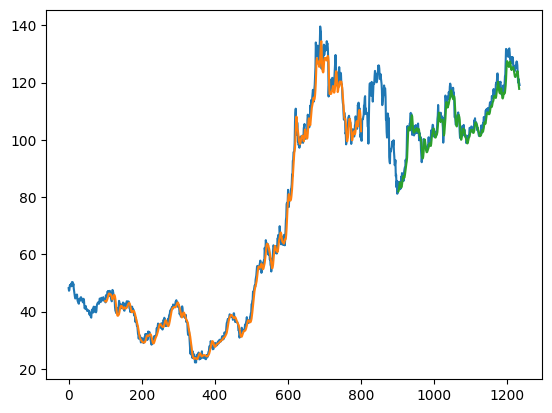

In [20]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [21]:
len(test_data)

433

In [22]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [23]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
temp_input

In [ ]:
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

In [26]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [27]:
len(df1)

1236

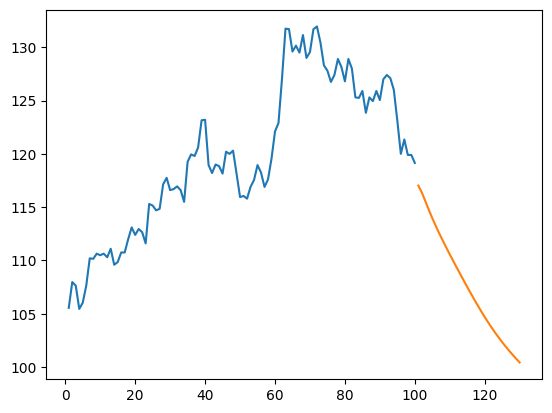

In [28]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))